## Stable Diffusion Image-to-Image Generation on IPU

This notebook demonstrates how a stable diffusion inference pipeline can be run on IPUs.

In [2]:

!pip install -r requirements.txt
!pip install "ipywidgets>=7,<8"
from examples_utils import notebook_logging
%load_ext gc_logger

  Cloning https://github.com/graphcore/examples-utils (to revision latest_stable) to /tmp/pip-install-g88b9z2l/examples-utils_0d16206c8877434a8e28c699d34ebfb9
  Running command git clone --filter=blob:none --quiet https://github.com/graphcore/examples-utils /tmp/pip-install-g88b9z2l/examples-utils_0d16206c8877434a8e28c699d34ebfb9
  Running command git checkout -q 0a5fb542bee036df8583678fdcef829351081eb6
  Resolved https://github.com/graphcore/examples-utils to commit 0a5fb542bee036df8583678fdcef829351081eb6
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 61.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 62.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 604.0/604.0 kB 51.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 58.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━

In [3]:
import os

pod_type = os.getenv("GRAPHCORE_POD_TYPE", "pod4")
executable_cache_dir = os.getenv("POPLAR_EXECUTABLE_CACHE_DIR", "/tmp/exe_cache/") + "/stablediffusion_to-image"

In [4]:
from huggingface_hub import notebook_login

notebook_login()

### Pipeline creation

In [5]:
import torch

from optimum.graphcore.diffusers import get_default_ipu_configs, INFERENCE_ENGINES_TO_MODEL_NAMES, IPUStableDiffusionImg2ImgPipeline

In [6]:
engine = "stable-diffusion-v1-5"  # maps to "runwayml/stable-diffusion-v1-5"
model_name = INFERENCE_ENGINES_TO_MODEL_NAMES[engine]
image_width = os.getenv("STABLE_DIFFUSION_IMG2IMG_DEFAULT_WIDTH", default=512)
image_height = os.getenv("STABLE_DIFFUSION_IMG2IMG_DEFAULT_HEIGHT", default=512)
image_dimensions = (image_width, image_height)

In [7]:
unet_ipu_config, text_encoder_ipu_config, vae_ipu_config, safety_checker_ipu_config = \
get_default_ipu_configs(
    engine=engine, width=image_width, height=image_height, pod_type=pod_type, 
    executable_cache_dir=executable_cache_dir 
)
pipe = IPUStableDiffusionImg2ImgPipeline.from_pretrained(
    model_name, 
    revision="fp16", 
    torch_dtype=torch.float16,
    unet_ipu_config=unet_ipu_config,
    text_encoder_ipu_config=text_encoder_ipu_config,
    vae_ipu_config=vae_ipu_config,
    safety_checker_ipu_config=safety_checker_ipu_config
)

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

In [8]:
from PIL import Image

pipe("apple", init_image=Image.new("RGB", image_dimensions), guidance_scale=7.5);

/usr/local/lib/python3.8/dist-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion_img2img.py:619: FutureWarning: The `init_image` argument is deprecated and will be removed in version 0.13.0. Please use `image` instead of `init_image`.
  init_image = deprecate("init_image", "0.13.0", message, take_from=kwargs)


  0%|          | 0/40 [00:00<?, ?it/s]


Graph compilation: 100%|██████████| 100/100 [11:17<00:00][A


### Image generation

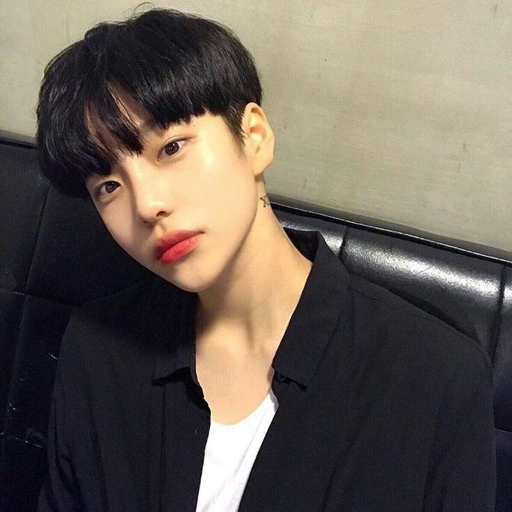

In [14]:
import requests
from io import BytesIO

url = "https://cdnb.artstation.com/p/assets/images/images/047/297/477/large/akela-martinosky-9fd32a73013ffce1c9cdca74f7e555ab.jpg?1647267944"

response = requests.get(url)
init_image = Image.open(BytesIO(response.content)).convert("RGB")
init_image = init_image.resize(image_dimensions)
init_image

  0%|          | 0/37 [00:00<?, ?it/s]

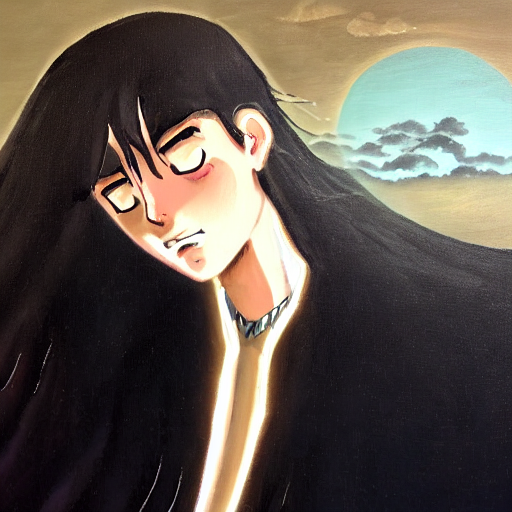

In [16]:
prompt = "A fantasy, oil painting, ghibli inspired"
out = pipe(prompt, init_image=init_image, strength=0.75, guidance_scale=7.5)
out.images[0]

## Saving the generated image

In [17]:
from matplotlib import pyplot as plt

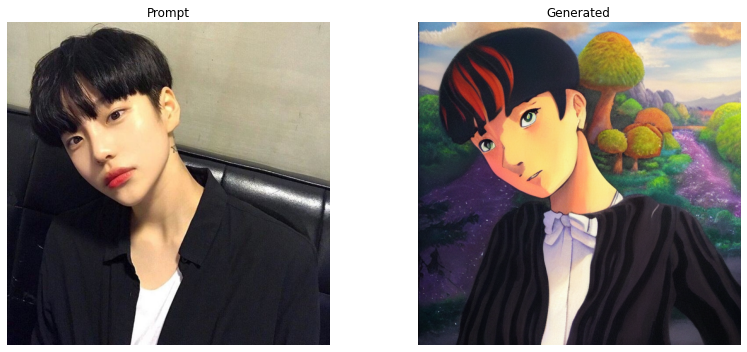

In [23]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(12, 5)
axs[0].imshow(init_image)
axs[0].set_title("Prompt")
axs[1].imshow(out.images[0])
axs[1].set_title("Generated")
axs[1].axis("off")
axs[0].axis("off")
fig.tight_layout()
fig.savefig("image_to_image.png", dpi=150)

### Release IPUs in use

In [18]:
pipe.detach_from_device()